# Data Embedding

## Column embedding using GloVe

In [152]:
import numpy as np
import torch
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Download and load pre-trained GloVe embeddings
from gensim.models import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format('glove.6B.100d.txt', no_header=True)

# Download and load pre-trained ELMo model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ainize/bart-base-cnn")
elmo_model = AutoModelForSequenceClassification.from_pretrained("ainize/bart-base-cnn")

# Define a function to preprocess text data
def preprocess_text(text):
  # Lowercase, remove punctuation, tokenize
  text = text.lower().strip().replace(",", " ").replace(".", " ")
  tokens = tokenizer.tokenize(text, return_tensors="pt")
  return tokens

# Load dataset
from datasets import load_dataset
data = load_dataset("imdb")

# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["train"]["text"], data["train"]["label"], test_size=0.2
)

# Function to get word embeddings (Glove or ELMO)
def get_embeddings(text, model_type="glove"):
  embeddings = []
  for word in text.split():
    if model_type == "glove":
      # Check if word exists in vocabulary
      if word in glove_model.key_to_index:
        embeddings.append(glove_model[word])
      else:
        embeddings.append(np.zeros(100))  # Use zero vector for missing words
    elif model_type == "elmo":
      # Get ELMo embeddings for the entire sentence
      with torch.no_grad():
        inputs = preprocess_text(text)
        encoded_layers = elmo_model(*inputs)
        embeddings = encoded_layers[0].squeeze(0).cpu().numpy()
    else:
      raise ValueError("Invalid model type. Choose 'glove' or 'elmo'.")
  # Average word embeddings to get sentence embedding
  return np.mean(embeddings, axis=0)


Some weights of the model checkpoint at ainize/bart-base-cnn were not used when initializing BartForSequenceClassification: ['lm_head.weight', 'final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at ainize/bart-base-cnn and are newly initialized: ['classification_head.out_proj.weight', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-strea

In [153]:
# Train and evaluate models with Glove and ELMO embeddings
def train_evaluate_model(embeddings, train_labels, test_labels):
  # Train a logistic regression model
  model = LogisticRegression(max_iter=1000)
  model.fit(embeddings, train_labels)
  predictions = model.predict(embeddings)
  accuracy = np.mean(predictions == train_labels)
  return accuracy

In [154]:
# Evaluate Glove and ELMO embeddings
glove_embeddings = [get_embeddings(text, model_type="glove") for text in train_texts]

glove_accuracy = train_evaluate_model(glove_embeddings, train_labels, test_labels)

print("Glove embedding accuracy:", glove_accuracy)

Glove embedding accuracy: 0.78885


In [155]:
import pandas as pd

In [156]:
customer_df = pd.read_csv("Customer.csv")

In [157]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID_Client          500 non-null    object
 1   Nom                500 non-null    object
 2   Prenom             500 non-null    object
 3   Genre              500 non-null    object
 4   Date_de_Naissance  500 non-null    object
 5   Adresse            500 non-null    object
 6   Telephone          500 non-null    int64 
 7   CIN                500 non-null    object
 8   flag_MRE           500 non-null    object
 9   flag_contencieux   500 non-null    object
 10  ID_Compte          500 non-null    object
 11  id_agence          500 non-null    object
dtypes: int64(1), object(11)
memory usage: 47.0+ KB


In [158]:
import os

In [159]:
tables = []
for i in os.listdir("./"):
    if os.path.splitext(i)[1] == ".csv" and i != "dev.csv":
        tables.append(i)
print(tables)

['Customer.csv', 'employee.csv', 'agences.csv', 'Account.csv', 'bank_card.csv', 'transactions.csv', 'loan.csv']


In [160]:
def column_to_string(column):
    str_column = f"{column.name} : "
    for i in column:
        str_column += str(i).strip()
        str_column += " ; "
    return str_column

### Test GloVe embeddings

In [161]:
column_to_string(customer_df.iloc[:100,0])

'ID_Client : 2b2b60cb-b97d-424d-9039-db36c03f7982 ; 84468f50-015a-4505-b0c6-38c6965836bb ; 8573dd9f-93d5-479e-a3d4-950373b6990e ; 3a290f5f-4d0a-4dd1-b528-f412efdcc12a ; 12d1b051-1826-4cf4-8479-4924d09579c4 ; 1240d5e4-0a68-461a-88c5-ebf8a4a7dbe1 ; b54fcfe6-efec-4004-85a7-5b1e526ca5b7 ; dd6fd8de-ed76-44d4-92d4-cf46bd24b59b ; c38cb71b-3c86-4fda-a512-6e8cc0e42b40 ; 29ee3aac-9e90-40e8-9dfa-2e59cc56db9d ; f4df3b11-ed9e-4be9-958f-695b9ed9f46e ; 4d01aba8-25a5-43ed-9045-74738d2ceaf7 ; a3f00928-c061-4dff-b8f7-73f9cc83c13a ; aa8a7853-b097-4005-9c2d-894f6eaf43c4 ; da736ccc-829c-471c-b71c-76f7f8c7710c ; 11b1bb46-539a-475f-b80c-9f68486f7c93 ; 84c1a4b7-e190-41a6-a499-82815c187788 ; 457e06c3-e341-4664-a979-0036c8114030 ; fd289064-c24b-4c7f-bed8-65268128132e ; ed4ec102-411c-4c61-af17-8fdf3163c70a ; a8573521-723c-498d-a993-df85cc54883a ; ca301047-499e-4814-b6fd-d51093b0a8b8 ; 8c621ec8-bc8d-49fa-b2cd-baf958f03e43 ; f4291abb-e5b0-409f-becb-11dedd45b02e ; 3e19ef5b-cc99-4a17-8751-3f9682adcb1d ; f2c2a532-bf5

In [162]:
get_embeddings(column_to_string(customer_df.iloc[:100,0]))

array([-0.16691377,  0.56829949,  0.22387921, -0.35015197,  0.06061648,
        0.26659148, -0.01140817, -0.02468678, -0.14532911,  0.09128574,
        0.35442013, -0.39204327, -0.02751832,  0.25548692,  0.31035029,
       -0.11726669,  0.1869744 , -0.09299787, -0.51034178,  0.46524059,
        0.11329896,  0.01742615,  0.27909093,  0.50068172,  0.29152628,
        0.3236739 , -0.06722518, -0.32064614,  0.07742485, -0.18274499,
       -0.04076911,  0.3990791 , -0.37115619, -0.18297866, -0.23774565,
        0.15535352,  0.3715582 ,  0.11803876,  0.05895143, -0.01844688,
        0.27270714, -0.63580424, -0.30855147, -0.23828867, -0.09045356,
       -0.25852604, -0.18488268, -0.37630323,  0.07656193, -0.06628599,
        0.16766049, -0.07349683,  0.00919045,  0.6262584 , -0.22987644,
       -1.2722381 ,  0.03635668, -0.20442812,  0.41372475,  0.21827357,
       -0.3284318 ,  0.26027167,  0.03036886, -0.05424629,  0.38054703,
       -0.22443569,  0.15651401,  0.00319777,  0.28646699,  0.14

### Create embeddings using GloVe

In [184]:
data = []
columns = []
for tab_name in tables:
    tab = pd.read_csv(tab_name)
    for column in tab:
        columns.append(column)
        data.append(list(get_embeddings(column_to_string(tab.loc[:200,column]))))

In [185]:
len(data)

55

In [186]:
data = pd.DataFrame(data, index = columns)

In [187]:
data.shape

(55, 100)

In [188]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ID_Client,-0.166384,0.568400,0.221222,-0.350721,0.061308,0.267381,-0.010562,-0.025128,-0.144777,0.092630,...,-0.052308,-0.275455,0.189930,0.204006,-0.567393,0.210087,-0.062517,-0.389973,0.279994,-0.371168
Nom,-0.163949,0.560082,0.217985,-0.345588,0.060411,0.263468,-0.010408,-0.024761,-0.142658,0.091275,...,-0.051542,-0.271424,0.187151,0.201021,-0.559090,0.207012,-0.061602,-0.384266,0.275897,-0.365736
Prenom,-0.165158,0.564210,0.219591,-0.348136,0.060856,0.265410,-0.010484,-0.024943,-0.143710,0.091948,...,-0.051922,-0.273425,0.188530,0.202503,-0.563211,0.208538,-0.062056,-0.387098,0.277931,-0.368432
Genre,-0.166384,0.568400,0.221222,-0.350721,0.061308,0.267381,-0.010562,-0.025128,-0.144777,0.092630,...,-0.052308,-0.275455,0.189930,0.204006,-0.567393,0.210087,-0.062517,-0.389973,0.279994,-0.371168
Date_de_Naissance,-0.166384,0.568400,0.221222,-0.350721,0.061308,0.267381,-0.010562,-0.025128,-0.144777,0.092630,...,-0.052308,-0.275455,0.189930,0.204006,-0.567393,0.210087,-0.062517,-0.389973,0.279994,-0.371168


### Clustring using Kmeans

In [189]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Step 1: Clustering for Initial Labeling
def clustering_for_initial_labeling(data):
    data.columns = data.columns.astype(str)
    # Perform K-Means clustering to create 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
    data['cluster'] = kmeans.fit_predict(data)

    # # Assign labels to clusters based on the most frequent true class
    # cluster_labels = data.groupby('cluster')['true_class'].agg(lambda x:x.value_counts().index[0])
    # data['cluster_label'] = data['cluster'].map(cluster_labels)

    return data

In [190]:
clustering_for_initial_labeling(data)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,cluster
ID_Client,-0.166384,0.568400,0.221222,-0.350721,0.061308,0.267381,-0.010562,-0.025128,-0.144777,0.092630,...,-0.275455,0.189930,0.204006,-0.567393,0.210087,-0.062517,-0.389973,0.279994,-0.371168,0
Nom,-0.163949,0.560082,0.217985,-0.345588,0.060411,0.263468,-0.010408,-0.024761,-0.142658,0.091275,...,-0.271424,0.187151,0.201021,-0.559090,0.207012,-0.061602,-0.384266,0.275897,-0.365736,0
Prenom,-0.165158,0.564210,0.219591,-0.348136,0.060856,0.265410,-0.010484,-0.024943,-0.143710,0.091948,...,-0.273425,0.188530,0.202503,-0.563211,0.208538,-0.062056,-0.387098,0.277931,-0.368432,0
Genre,-0.166384,0.568400,0.221222,-0.350721,0.061308,0.267381,-0.010562,-0.025128,-0.144777,0.092630,...,-0.275455,0.189930,0.204006,-0.567393,0.210087,-0.062517,-0.389973,0.279994,-0.371168,0
Date_de_Naissance,-0.166384,0.568400,0.221222,-0.350721,0.061308,0.267381,-0.010562,-0.025128,-0.144777,0.092630,...,-0.275455,0.189930,0.204006,-0.567393,0.210087,-0.062517,-0.389973,0.279994,-0.371168,0
Adresse,-0.059605,0.193254,0.099159,-0.141299,0.051945,0.097593,0.001776,0.010090,-0.044904,0.025702,...,-0.129642,0.083101,0.095543,-0.241179,0.103329,-0.042486,-0.174243,0.115096,-0.122924,2
Telephone,-0.166384,0.568400,0.221222,-0.350721,0.061308,0.267381,-0.010562,-0.025128,-0.144777,0.092630,...,-0.275455,0.189930,0.204006,-0.567393,0.210087,-0.062517,-0.389973,0.279994,-0.371168,0
CIN,-0.166384,0.568400,0.221222,-0.350721,0.061308,0.267381,-0.010562,-0.025128,-0.144777,0.092630,...,-0.275455,0.189930,0.204006,-0.567393,0.210087,-0.062517,-0.389973,0.279994,-0.371168,0
flag_MRE,-0.166384,0.568400,0.221222,-0.350721,0.061308,0.267381,-0.010562,-0.025128,-0.144777,0.092630,...,-0.275455,0.189930,0.204006,-0.567393,0.210087,-0.062517,-0.389973,0.279994,-0.371168,0
flag_contencieux,-0.166384,0.568400,0.221222,-0.350721,0.061308,0.267381,-0.010562,-0.025128,-0.144777,0.092630,...,-0.275455,0.189930,0.204006,-0.567393,0.210087,-0.062517,-0.389973,0.279994,-0.371168,0


In [191]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Function to plot 2D representation of 10-dimensional vectors
def plot_2d_representation(data, labels, names):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        indices = labels == label
        plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=f'Label {label}', alpha=0.7)
        for i, name in enumerate(names):
            if indices[i]:
                plt.text(reduced_data[i, 0], reduced_data[i, 1], name, fontsize=8, ha='right', va='bottom')

    plt.title('2D Representation of 10-dimensional Vectors with Annotations')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

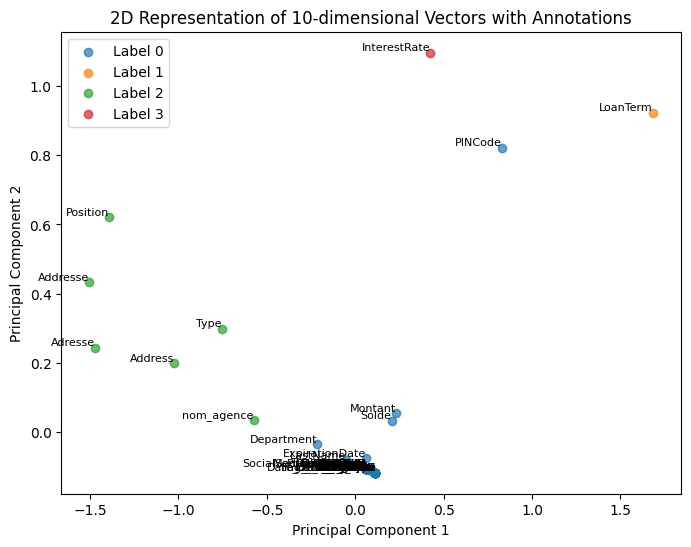

In [192]:
plot_2d_representation(data.iloc[:,:-1], data.iloc[:,-1], data.index)